**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Load & Clean**

Load

In [2]:
df = pd.read_csv("/content/META stocks.csv")

normalize column names


In [3]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

fix date

In [4]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").drop_duplicates(subset="date")

fill adj_close if missing

In [5]:
if "adj_close" not in df.columns and "close" in df.columns:
    df["adj_close"] = df["close"]
df["adj_close"] = df["adj_close"].fillna(df.get("close"))

ensure numeric

In [6]:
for c in ["open","high","low","close","adj_close","volume"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

**Feature Engineering**

In [7]:
df["daily_return"] = df["adj_close"].pct_change()
df["sma_20"] = df["adj_close"].rolling(20).mean()
df["sma_50"] = df["adj_close"].rolling(50).mean()
df["sma_200"] = df["adj_close"].rolling(200).mean()
df["vol_30d_ann"] = df["daily_return"].rolling(30).std() * np.sqrt(252)
df["drawdown"] = df["adj_close"] / df["adj_close"].cummax() - 1
df["weekday"] = df["date"].dt.day_name()
df["month"] = df["date"].dt.month
df["month_lbl"] = df["date"].dt.strftime("%b")
df["year"] = df["date"].dt.year

**Visuals**

Price with SMAs

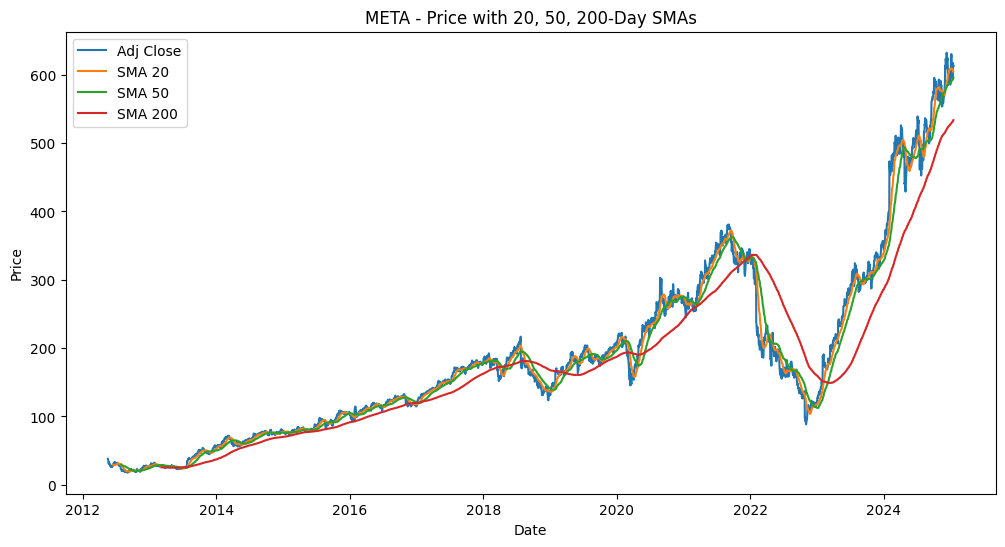

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["adj_close"], label="Adj Close")
plt.plot(df["date"], df["sma_20"], label="SMA 20")
plt.plot(df["date"], df["sma_50"], label="SMA 50")
plt.plot(df["date"], df["sma_200"], label="SMA 200")
plt.title("META - Price with 20, 50, 200-Day SMAs")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

Candlestick-style (High-Low vs Close)

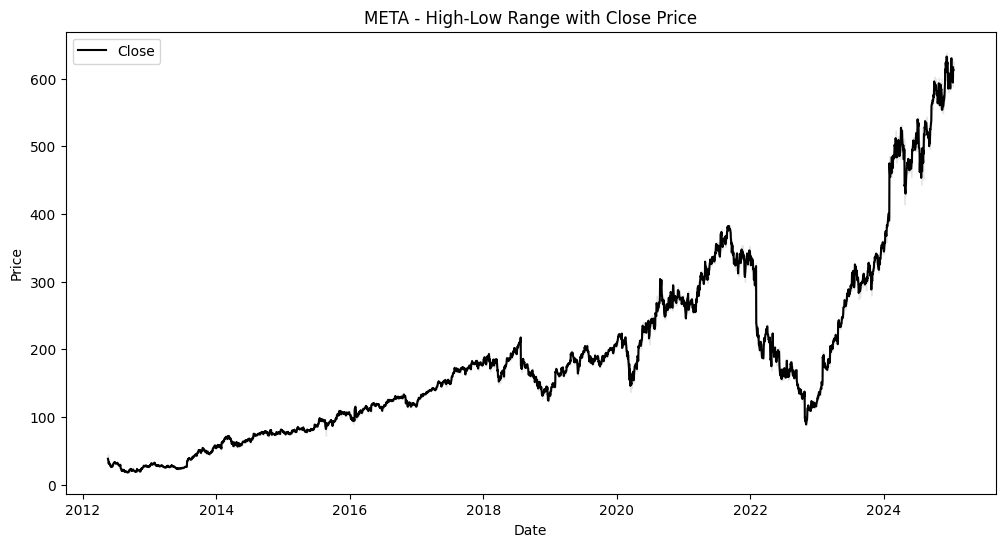

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["close"], label="Close", color="black")
plt.fill_between(df["date"], df["low"], df["high"], color="lightgray", alpha=0.5)
plt.title("META - High-Low Range with Close Price")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend()
plt.show()

Volume

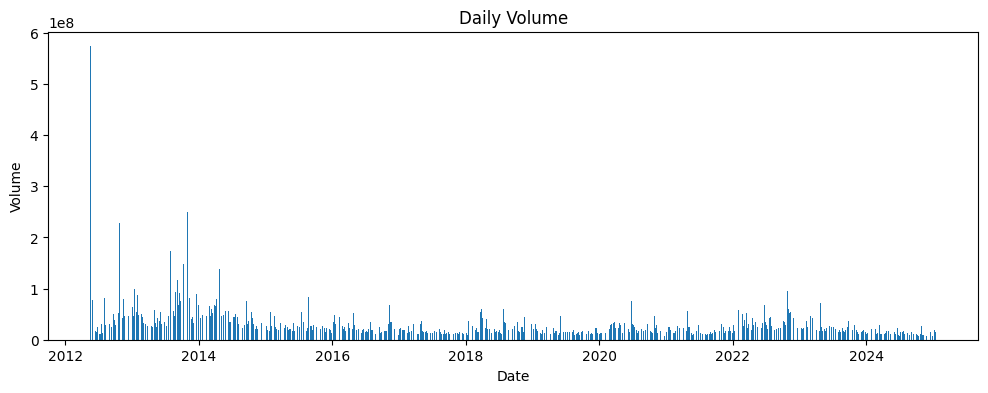

In [10]:
plt.figure(figsize=(12,4))
plt.bar(df["date"], df["volume"])
plt.title("Daily Volume")
plt.xlabel("Date"); plt.ylabel("Volume")
plt.show()

Price & Volume together

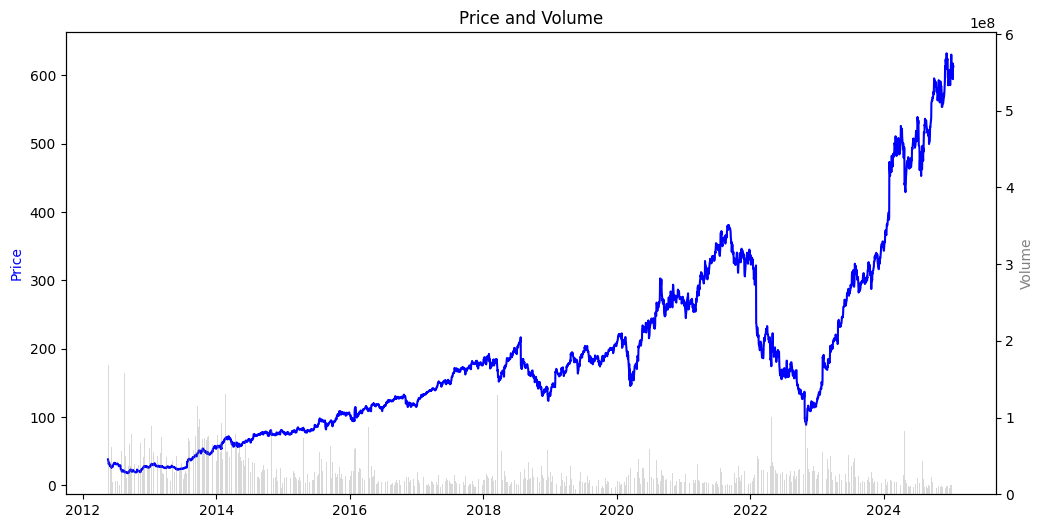

In [11]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df["date"], df["adj_close"], color="blue")
ax1.set_ylabel("Price", color="blue")
ax2 = ax1.twinx()
ax2.bar(df["date"], df["volume"], alpha=0.3, color="gray")
ax2.set_ylabel("Volume", color="gray")
plt.title("Price and Volume")
plt.show()

Daily Returns (time series)

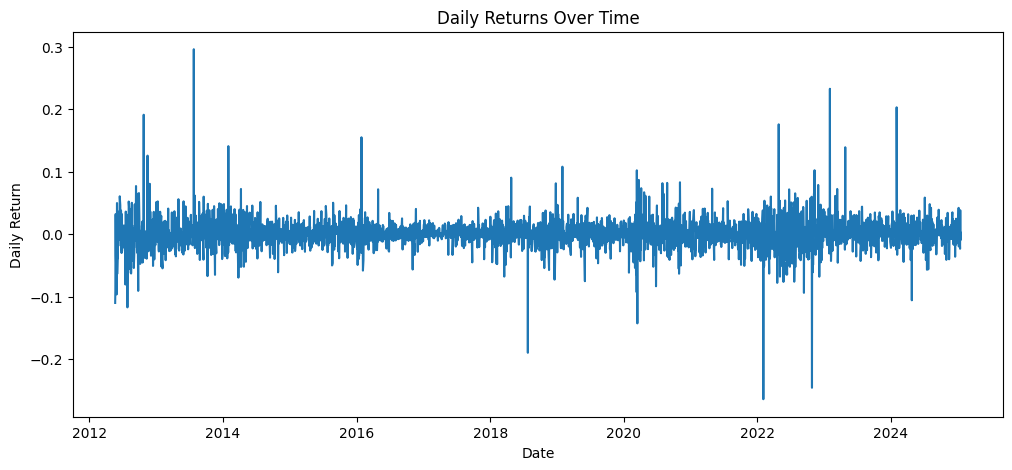

In [12]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["daily_return"])
plt.title("Daily Returns Over Time")
plt.xlabel("Date"); plt.ylabel("Daily Return")
plt.show()

 Histogram of Daily Returns

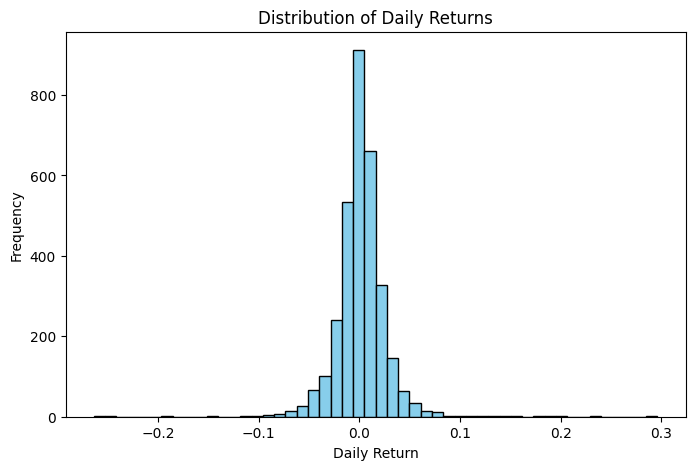

In [13]:
plt.figure(figsize=(8,5))
plt.hist(df["daily_return"].dropna(), bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return"); plt.ylabel("Frequency")
plt.show()

Rolling Volatility

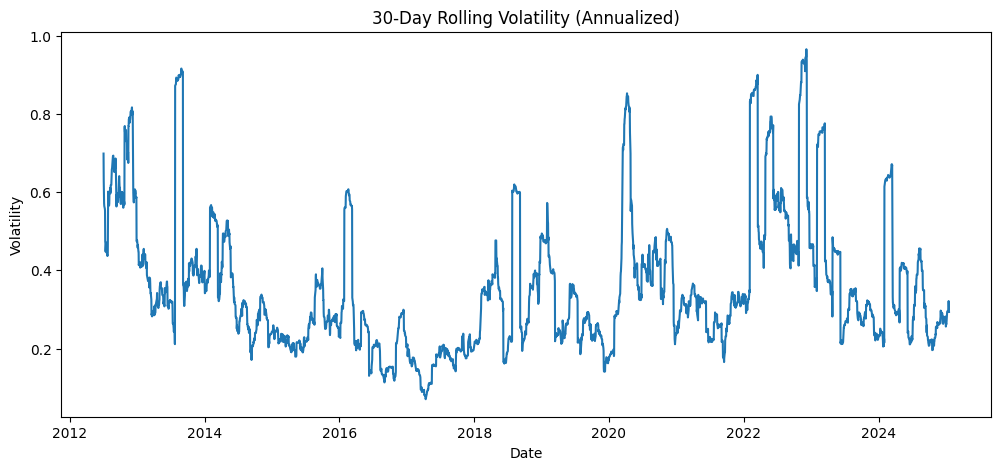

In [14]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["vol_30d_ann"])
plt.title("30-Day Rolling Volatility (Annualized)")
plt.xlabel("Date"); plt.ylabel("Volatility")
plt.show()

Drawdown

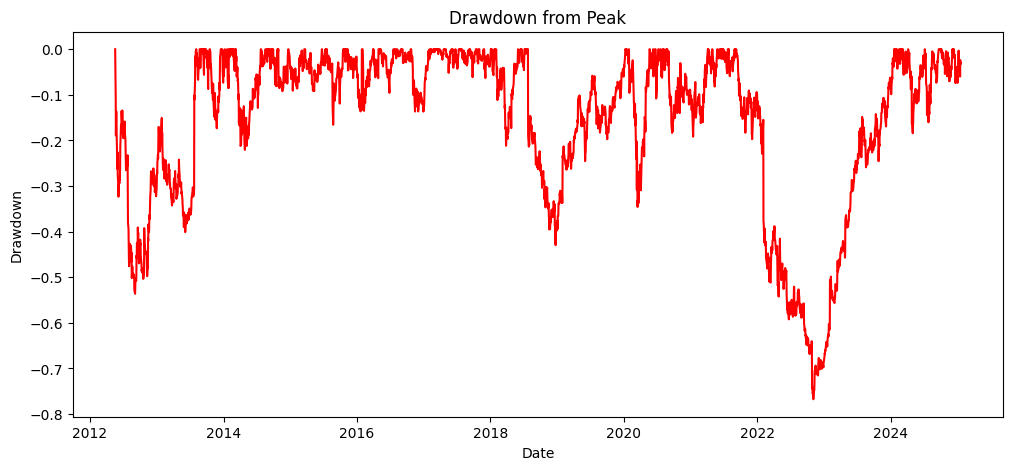

In [15]:
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["drawdown"], color="red")
plt.title("Drawdown from Peak")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.show()

Cumulative Returns

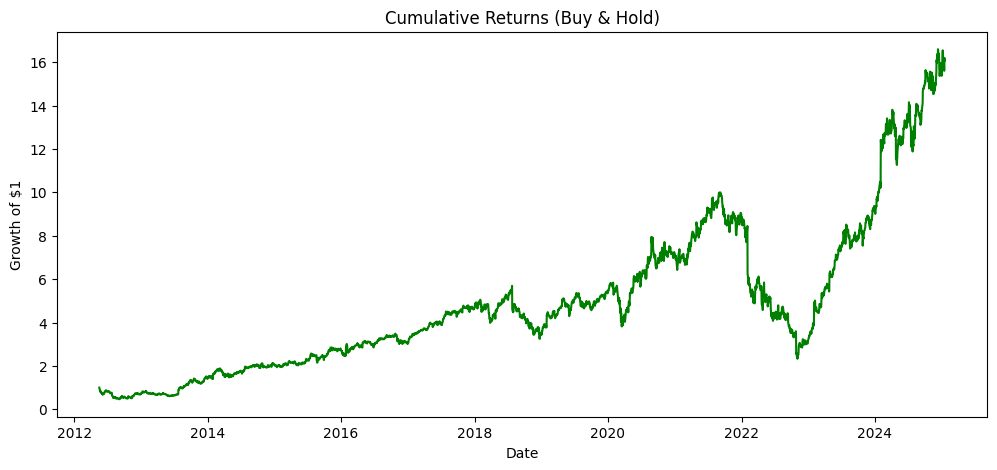

In [16]:
cum = (1 + df["daily_return"].fillna(0)).cumprod()
plt.figure(figsize=(12,5))
plt.plot(df["date"], cum, color="green")
plt.title("Cumulative Returns (Buy & Hold)")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.show()

Top 10 Best & Worst Days

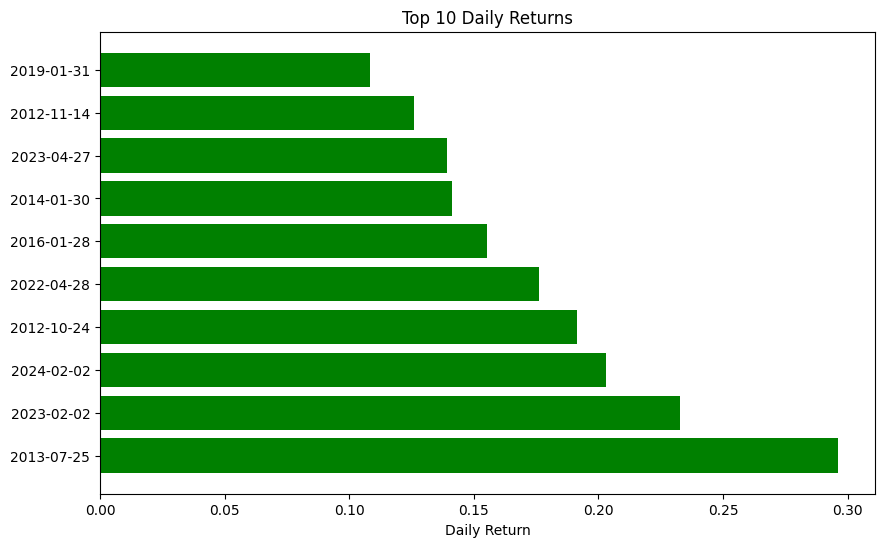

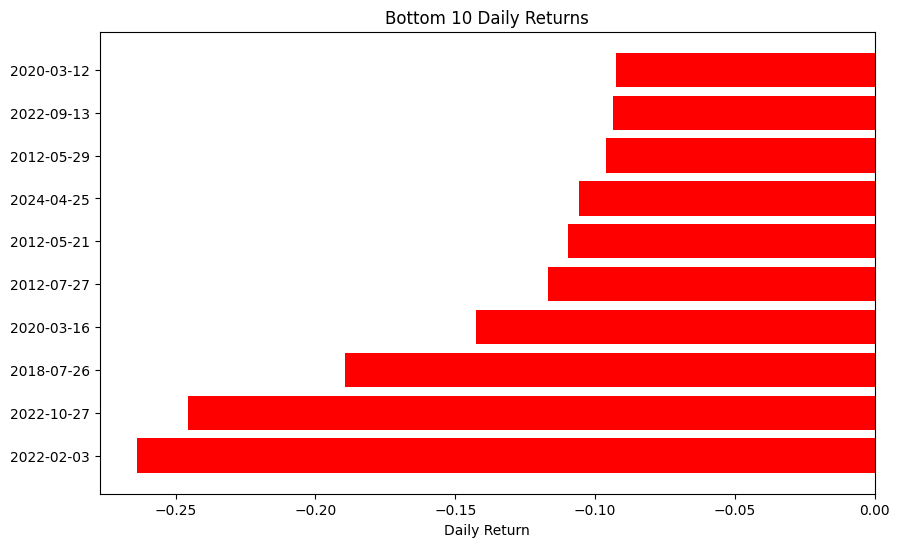

In [17]:
top10 = df.nlargest(10, "daily_return")[["date","daily_return"]]
bottom10 = df.nsmallest(10, "daily_return")[["date","daily_return"]]

plt.figure(figsize=(10,6))
plt.barh(top10["date"].dt.strftime("%Y-%m-%d"), top10["daily_return"], color="green")
plt.title("Top 10 Daily Returns"); plt.xlabel("Daily Return")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(bottom10["date"].dt.strftime("%Y-%m-%d"), bottom10["daily_return"], color="red")
plt.title("Bottom 10 Daily Returns"); plt.xlabel("Daily Return")
plt.show()

Average Return by Weekday

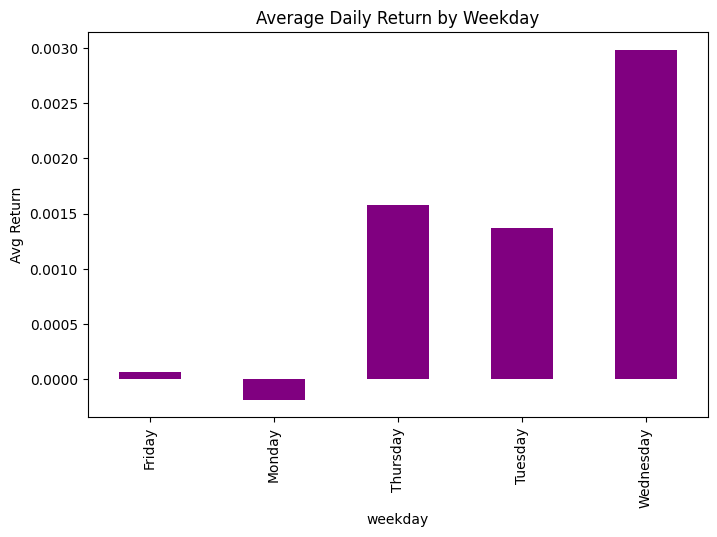

In [18]:
wk = df.groupby("weekday")["daily_return"].mean()
plt.figure(figsize=(8,5))
wk.plot(kind="bar", color="purple")
plt.title("Average Daily Return by Weekday")
plt.ylabel("Avg Return")
plt.show()

Average Return by Month

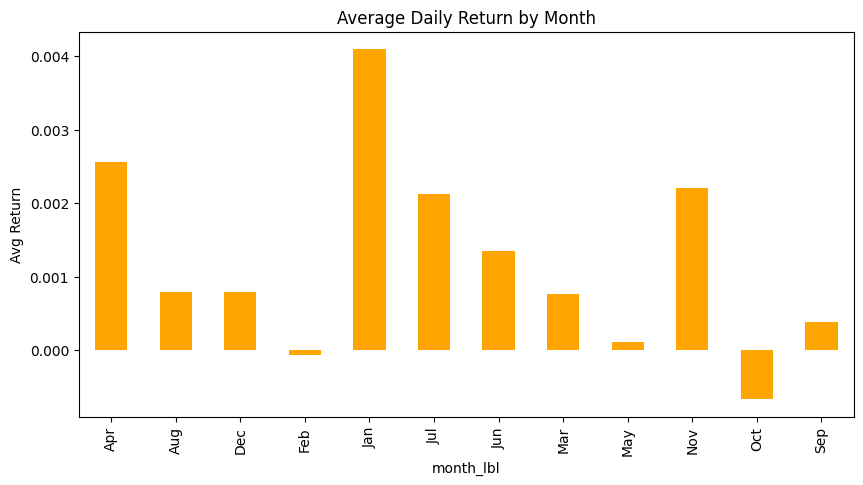

In [19]:
mm = df.groupby("month_lbl")["daily_return"].mean()
plt.figure(figsize=(10,5))
mm.plot(kind="bar", color="orange")
plt.title("Average Daily Return by Month")
plt.ylabel("Avg Return")
plt.show()

Monthly Compounded Returns

/tmp/ipython-input-3472492125.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index("date")["daily_return"].resample("M").apply(lambda x: (1+x).prod()-1)


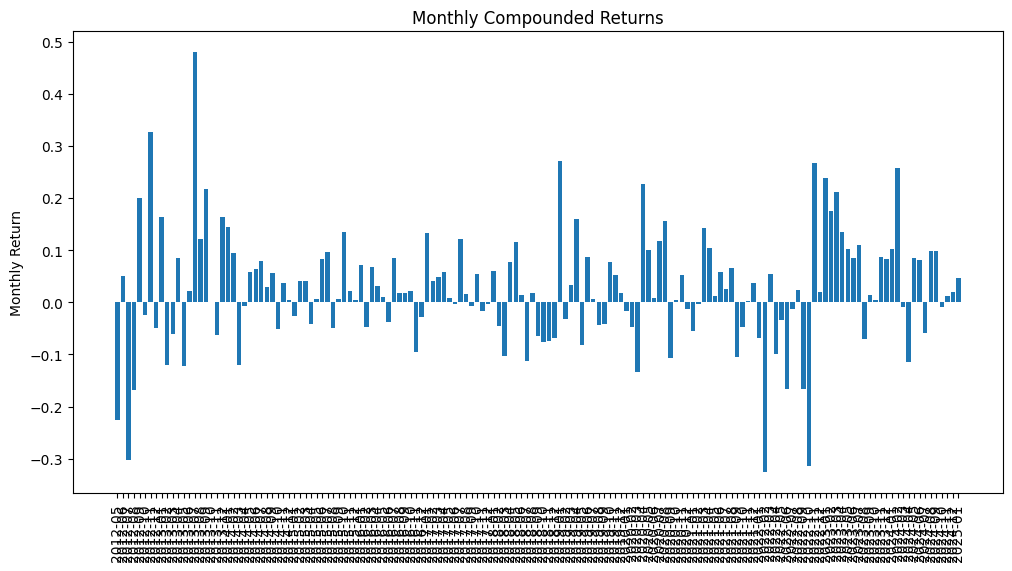

In [20]:
monthly = df.set_index("date")["daily_return"].resample("M").apply(lambda x: (1+x).prod()-1)
plt.figure(figsize=(12,6))
plt.bar(monthly.index.strftime("%Y-%m"), monthly.values)
plt.title("Monthly Compounded Returns")
plt.xticks(rotation=90)
plt.ylabel("Monthly Return")
plt.show()

Yearly Compounded Returns

/tmp/ipython-input-109611396.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly = df.set_index("date")["daily_return"].resample("Y").apply(lambda x: (1+x).prod()-1)


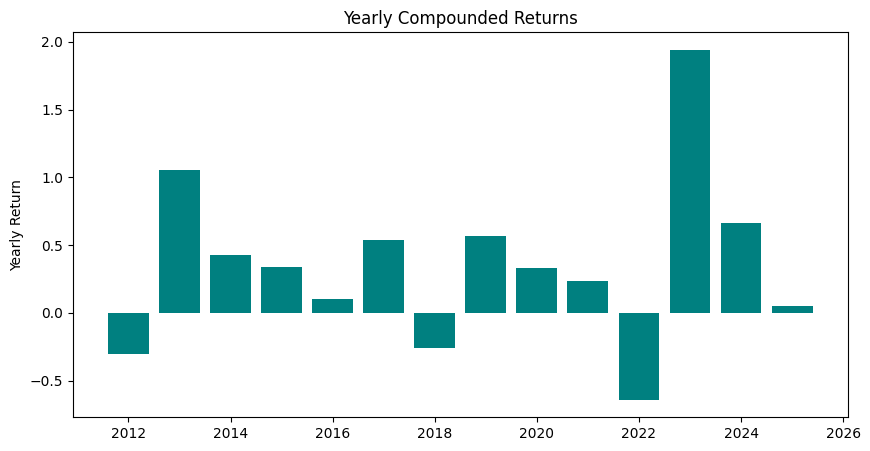

In [21]:
yearly = df.set_index("date")["daily_return"].resample("Y").apply(lambda x: (1+x).prod()-1)
plt.figure(figsize=(10,5))
plt.bar(yearly.index.year, yearly.values, color="teal")
plt.title("Yearly Compounded Returns")
plt.ylabel("Yearly Return")
plt.show()

Boxplot of Returns by Weekday

<Figure size 1000x600 with 0 Axes>

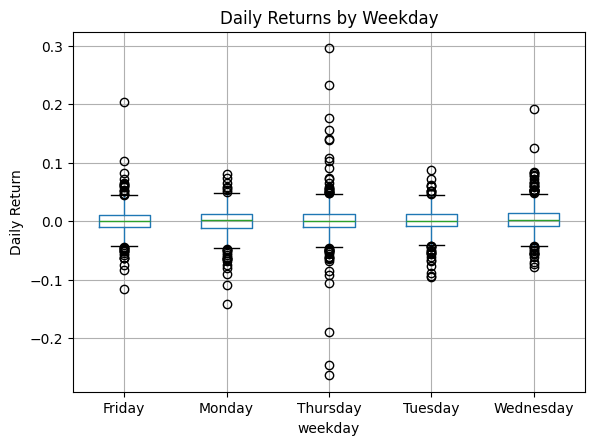

In [22]:
plt.figure(figsize=(10,6))
df.boxplot(column="daily_return", by="weekday")
plt.title("Daily Returns by Weekday"); plt.suptitle("")
plt.ylabel("Daily Return")
plt.show()

Boxplot of Returns by Year

<Figure size 1200x600 with 0 Axes>

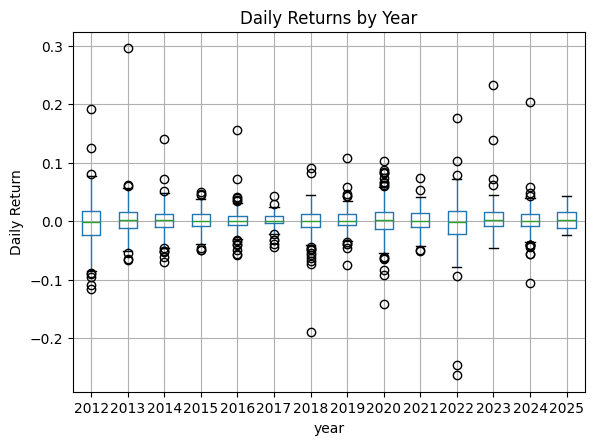

In [23]:
plt.figure(figsize=(12,6))
df.boxplot(column="daily_return", by="year")
plt.title("Daily Returns by Year"); plt.suptitle("")
plt.ylabel("Daily Return")
plt.show()

Price with Volume Spike markers

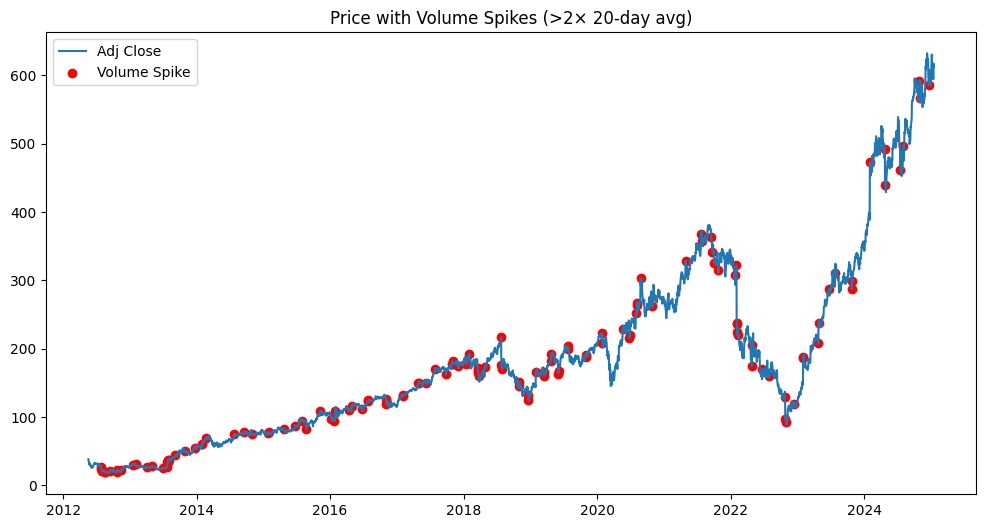

In [24]:
df["vol_ma20"] = df["volume"].rolling(20).mean()
df["vol_spike"] = df["volume"] > 2 * df["vol_ma20"]

plt.figure(figsize=(12,6))
plt.plot(df["date"], df["adj_close"], label="Adj Close")
plt.scatter(df.loc[df["vol_spike"], "date"], df.loc[df["vol_spike"], "adj_close"],
            color="red", label="Volume Spike", marker="o")
plt.title("Price with Volume Spikes (>2× 20-day avg)")
plt.legend(); plt.show()

Price with Extreme Return markers

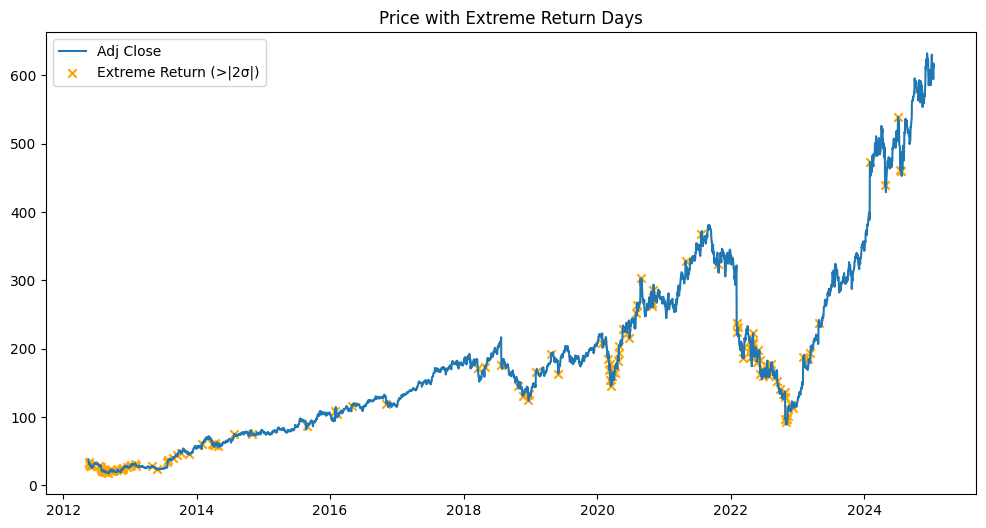

In [25]:
ret_std = df["daily_return"].std()
df["extreme_ret"] = abs(df["daily_return"]) > 2 * ret_std

plt.figure(figsize=(12,6))
plt.plot(df["date"], df["adj_close"], label="Adj Close")
plt.scatter(df.loc[df["extreme_ret"], "date"], df.loc[df["extreme_ret"], "adj_close"],
            color="orange", label="Extreme Return (>|2σ|)", marker="x")
plt.title("Price with Extreme Return Days")
plt.legend(); plt.show()

In [26]:
# Assuming your cleaned + enriched DataFrame is called df
df.to_csv("meta_cleaned_with_indicators.csv", index=False)